In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.svm import SVR

## Data processing

In [2]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
data_rain_ck = pd.read_csv('data_mrc/Rainfall_ChiangKhan.csv')
data_flow_ck = pd.read_csv('data_mrc/Discharge_ChiangKhan.csv')
data_gdp = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_rain_ck = data_rain_ck.rename(columns={'Value': 'rainfall_ck'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
data_flow_ck = data_flow_ck.rename(columns={'Value': 'flowrate_ck'})
data_gdp = data_gdp.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_rain_ck = data_rain_ck[['Timestamp (UTC+07:00)', 'rainfall_ck']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]
data_flow_ck = data_flow_ck[['Timestamp (UTC+07:00)', 'flowrate_ck']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_rain_ck, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_flow_ck, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%dT%H:%M%z')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()
df['min_flow_month_ck'] = df['flowrate_ck'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks'] = df['rainfall'].rolling(window=35, min_periods=1).sum()

df['rainfall_lag1_ck'] = df['rainfall_ck'].shift(1)
df['rainfall_lag2_ck'] = df['rainfall_ck'].shift(2)
df['rainfall_lag3_ck'] = df['rainfall_ck'].shift(3)
df['rainfall_lag5weeks_ck'] = df['rainfall_ck'].shift(35)
df['rainfall_week_ck'] = df['rainfall_ck'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks_ck'] = df['rainfall_ck'].rolling(window=35, min_periods=1).sum()

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# merge with gdp data
df = pd.merge(df, data_gdp, on='year', how='left')

# scale data
scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']] \
    = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']])
scaler_flow = StandardScaler()
df[['flowrate', 'min_flow_week','min_flow_month']] = scaler_flow.fit_transform(df[['flowrate', 'min_flow_week','min_flow_month']])
scaler_flow_ck = StandardScaler()
df[['flowrate_ck','min_flow_month_ck']] = scaler_flow_ck.fit_transform(df[['flowrate_ck', 'min_flow_month_ck']])
scaler_gdp = StandardScaler()
df[['gdp']] = scaler_gdp.fit_transform(df[['gdp']])

In [3]:
# drop rows with missing values
df.dropna(inplace=True)

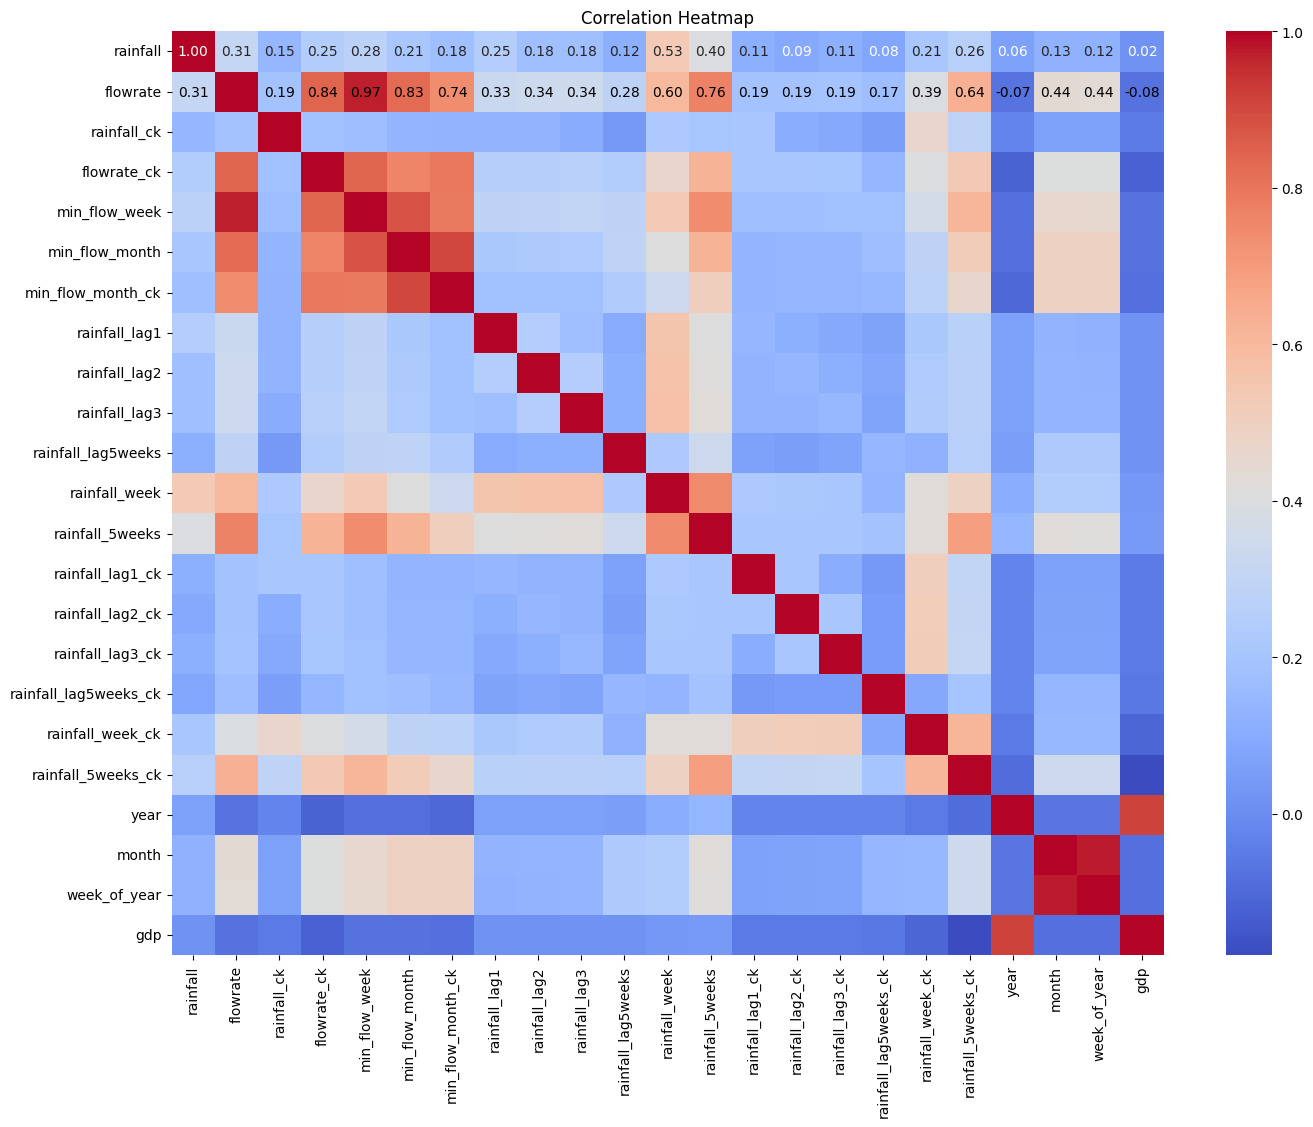

In [4]:
## heatmap ##
plt.figure(figsize=(16, 12))
corr = df.corr()

ax = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Custom annotations for the "flowrate" row
for i in range(len(corr.columns)):
    if corr.index[i] == 'flowrate':
        for j in range(len(corr.columns)):
            if corr.columns[j] != 'flowrate':
                ax.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", 
                        color='black', ha='center', va='center')
plt.title('Correlation Heatmap')
plt.show()

## Models

In [5]:
X = df[['rainfall', 'year', 'month', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_week', 'rainfall_5weeks', 'min_flow_month']]
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
X_ck = df[['rainfall_ck', 'year', 'month', 'week_of_year', 'rainfall_lag1_ck', 'rainfall_lag2_ck', 'rainfall_lag3_ck', 'rainfall_lag5weeks_ck', 'rainfall_week_ck', 'rainfall_5weeks_ck', 'min_flow_month_ck']]
y_ck = df['flowrate_ck']

X_train_ck, X_test_ck, y_train_ck, y_test_ck = train_test_split(X_ck, y_ck, test_size=0.2, shuffle=False)

In [7]:
quantile = 0.25
qr_model = QuantileRegressor(quantile=quantile, solver ='highs')

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0]  # Regularization strength
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(qr_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print(f"Quantile Regression Model for quantile = {quantile}")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R-squared: {mean_r2:.4f} ± {std_r2:.4f}")

Quantile Regression Model for quantile = 0.25
Mean Cross-Validation MSE: 0.3654 ± 0.0393
Mean Cross-Validation R-squared: 0.6571 ± 0.0246


In [8]:
quantile_ck = 0.28
qr_model_ck = QuantileRegressor(quantile=quantile, solver ='highs')

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0]  # Regularization strength
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores_ck = []
outer_cv_r2_scores_ck = []

# Perform nested cross-validation
for train_idx_ck, val_idx_ck in outer_cv.split(X_train_ck, y_train_ck):
    X_train_fold, X_val_fold = X_train_ck.iloc[train_idx_ck], X_train_ck.iloc[val_idx_ck]
    y_train_fold, y_val_fold = y_train_ck.iloc[train_idx_ck], y_train_ck.iloc[val_idx_ck]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(qr_model_ck, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model_ck = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred_ck = best_model_ck.predict(X_val_fold)
    mse_score_ck = mean_squared_error(y_val_fold, y_pred_ck)
    r2_score_value_ck = r2_score(y_val_fold, y_pred_ck)
    
    # Store the results
    outer_cv_mse_scores_ck.append(mse_score_ck)
    outer_cv_r2_scores_ck.append(r2_score_value_ck)

# Calculate the mean and standard deviation of the scores
mean_mse_ck = np.mean(outer_cv_mse_scores_ck)
std_mse_ck = np.std(outer_cv_mse_scores_ck)
mean_r2_ck = np.mean(outer_cv_r2_scores_ck)
std_r2_ck = np.std(outer_cv_r2_scores_ck)

# Print cross-validation results
print(f"Quantile Regression Model for quantile = {quantile} (Chiang Khan)")
print(f"Mean Cross-Validation MSE: {mean_mse_ck:.4f} ± {std_mse_ck:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2_ck:.4f} ± {std_r2_ck:.4f}")

Quantile Regression Model for quantile = 0.25 (Chiang Khan)
Mean Cross-Validation MSE: 0.5030 ± 0.0426
Mean Cross-Validation R²: 0.5135 ± 0.0267


## Best model evaluated on test set

In [9]:
# Train the best model on the entire training set
grid_search = GridSearchCV(qr_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the held-out test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print test set evaluation
print(f"\nRegression Model (Test Set Evaluation) for q= {quantile}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")


Regression Model (Test Set Evaluation) for q= 0.25
Test MSE: 0.2256
Test R-squared: 0.6715


In [10]:
# Train the best model on the entire training set
grid_search = GridSearchCV(qr_model_ck, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train_ck, y_train_ck)

# Get the best model from the grid search
best_model_ck = grid_search.best_estimator_

# Evaluate the best model on the held-out test set
y_test_pred_ck = best_model_ck.predict(X_test_ck)
test_mse_ck = mean_squared_error(y_test_ck, y_test_pred_ck)
test_r2_ck = r2_score(y_test_ck, y_test_pred_ck)

# Print test set evaluation
print(f"\nRegression Model (Test Set Evaluation) for q= {quantile}")
print(f"Test MSE: {test_mse_ck:.4f}")
print(f"Test R-squared: {test_r2_ck:.4f}")


Regression Model (Test Set Evaluation) for q= 0.25
Test MSE: 0.2276
Test R-squared: 0.5605


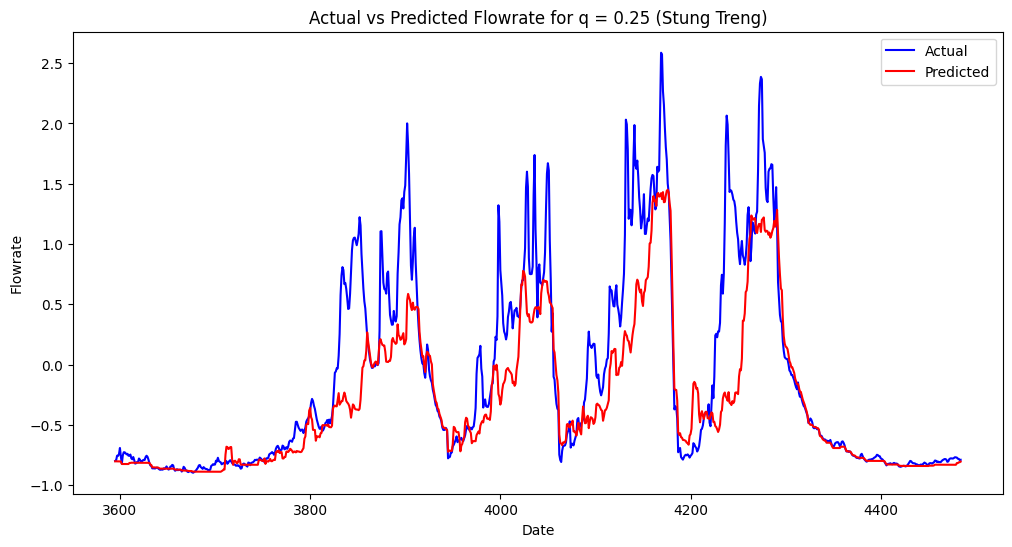

In [11]:
## plot actual vs predicted ##
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red')
plt.title(f'Actual vs Predicted Flowrate for q = {quantile} (Stung Treng)')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

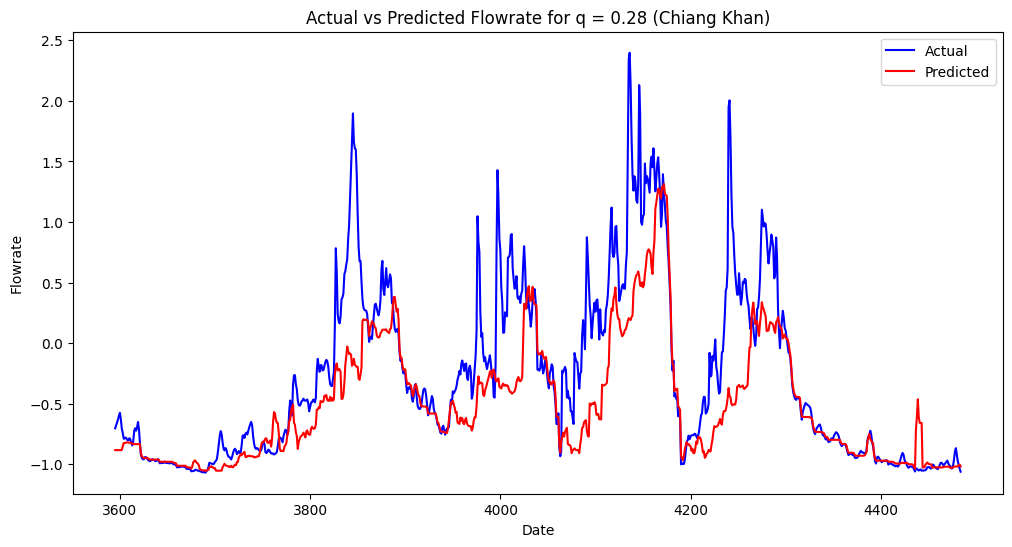

In [12]:
# plot actual vs predicted (Chiang Khan)
plt.figure(figsize=(12, 6))
plt.plot(y_test_ck.index, y_test_ck, label='Actual', color='blue')
plt.plot(y_test_ck.index, y_test_pred_ck, label='Predicted', color='red')
plt.title(f'Actual vs Predicted Flowrate for q = {quantile_ck} (Chiang Khan)')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()